# 02 - Feature Extraction

**Goal:** Extract high-level feature representations from CIFAR-10 using pretrained ResNet50

## Overview
In this notebook, we will:
1. Load the full CIFAR-10 dataset
2. Extract 2048-dimensional features using ResNet50
3. Apply PCA to reduce dimensionality to 50D
4. Visualize the reduced feature space
5. Save features for TDA analysis

**Why Feature Extraction?**
- Raw pixels (32×32×3 = 3,072 dims) are noisy and high-dimensional
- ResNet50 learns semantic features (objects, textures, shapes)
- These features are better suited for TDA

### Setup and Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.manifold import TSNE

# Our modules
from src.data.cifar10 import load_cifar10
from src.models.feature_extractor import FeatureExtractor, DimensionalityReducer

### Load the CIFAR-10 Dataset

In [2]:
(training_images, training_labels), (validation_images, validation_labels), (testing_images, testing_labels), class_names = load_cifar10()

print(f"\nUsing {len(training_images):,} training samples for feature extraction")


Final splits:
Training:   45000 samples
Validation: 5000 samples
Testing:    10000 samples

Using 45,000 training samples for feature extraction


### Initialize Feature Extractor

We'll use **ResNet50** pretrained on ImageNet:
- **2048-dimensional** feature vectors
- Captures high-level semantic information

In [3]:
extractor = FeatureExtractor(model_name='resnet50')   # Initialize the extractor

2025-11-30 23:19:43.013175: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-30 23:19:43.013576: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-30 23:19:43.013580: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-30 23:19:43.013625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 23:19:43.013870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Model: resnet50
Feature dimension: 2048
Total parameters: 23,587,712


### Extract Features from Training Set

This step processes each image through ResNet50 to extract feature vectors.  
**Expected time:** ~2-3 minutes for 5,000 images on CPU

In [4]:
clean_features = extractor.extract_features(
    training_images, 
    batch_size=64,
    resize_to=224,
    verbose=True
)

print(f"\nFeature extraction complete")


Feature extraction in progress... :   0%|          | 0/704 [00:00<?, ?batch/s]2025-11-30 23:19:49.961421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.

Feature extraction in progress... : 100%|██████████| 704/704 [09:30<00:00,  1.23batch/s]



Extracted features from 45,000 images
Feature shape: (45000, 2048)
Feature range: [0.000, 17.525]

Feature extraction complete


### Feature Statistics

Let's analyze the extracted features before dimensionality reduction:

In [5]:
print(f"Shape: {clean_features.shape}")
print(f"{clean_features.shape[0]:,} samples x {clean_features.shape[1]:,} dimensions")

print(f"\nValue Range:")
print(f"Min:    {clean_features.min():.4f}")
print(f"Max:    {clean_features.max():.4f}")
print(f"Mean:   {clean_features.mean():.4f}")
print(f"Std:    {clean_features.std():.4f}")

print(f"\nSparsity:")
zero_ratio = (clean_features == 0).sum() / clean_features.size
print(f"{zero_ratio:.2%} of feature values are exactly zero")

Shape: (45000, 2048)
45,000 samples x 2,048 dimensions

Value Range:
Min:    0.0000
Max:    17.5249
Mean:   0.0910
Std:    0.6064

Sparsity:
78.00% of feature values are exactly zero


These numbers have no natural units; they represent activation strength. We can think of each number like a score:
- 0 → this feature wasn’t present
- 17.5246 → this feature appeared strongly
- 0.091 mean → most features are weakly activated on average
- std 0.6064 → most values cluster < 1, a few rare spikes go higher

Each feature is a completely different concept, so its scale doesn’t matter relative to another feature. What actually matters is:
- Patterns across **ALL** 2048 numbers
- Which features activate together
- How feature vectors cluster in space

That’s why **PCA** is useful since it captures the geometry of these activation patterns.

### Apply PCA Dimensionality Reduction

**Why reduce dimensions?**
- 2048 dimensions is computationally expensive for TDA
- However, 50 dimensions is fast while also preserving approximately 95% of variance
- Removes noise and redundant information

In [6]:
reducer = DimensionalityReducer(n_components=50, random_state=111)             # PCA reducer
clean_features_reduced = reducer.fit_transform(clean_features, verbose=True)   # Fit and transform features

print(f"PCA dimensionality reduction complete")
print(f"Original: {clean_features.shape}")
print(f"Reduced:  {clean_features_reduced.shape}")


Applying PCA...
Original feature dimension: 2048
Target dimension: 50
PCA dimensionality reduction complete
Original: (45000, 2048)
Reduced:  (45000, 50)


### Visualize Variance Explained by PCA

Let's plot how much information each principal component captures:

Saved variance plot to: ../results/figures/02_pca_variance.png


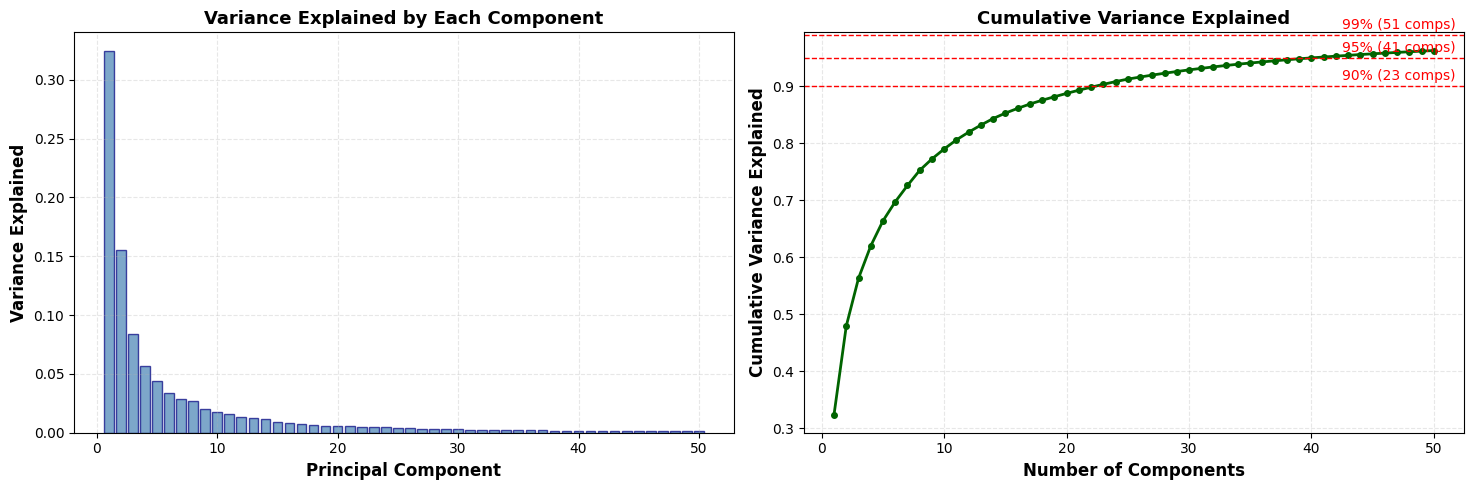

In [7]:
reducer.plot_variance_explained(save_path='../results/figures/02_pca_variance.png')   # Variance explained

### Visualize Reduced Feature Space (2D Projection using t-SNE)

Let's use t-SNE to project 50D features to 2D for visualization.  
**Note:** This is just for visualization; we'll use 50D features for TDA.

In [8]:
tsne = TSNE(n_components=2, perplexity=30, random_state=111)
features_2d = tsne.fit_transform(clean_features_reduced)

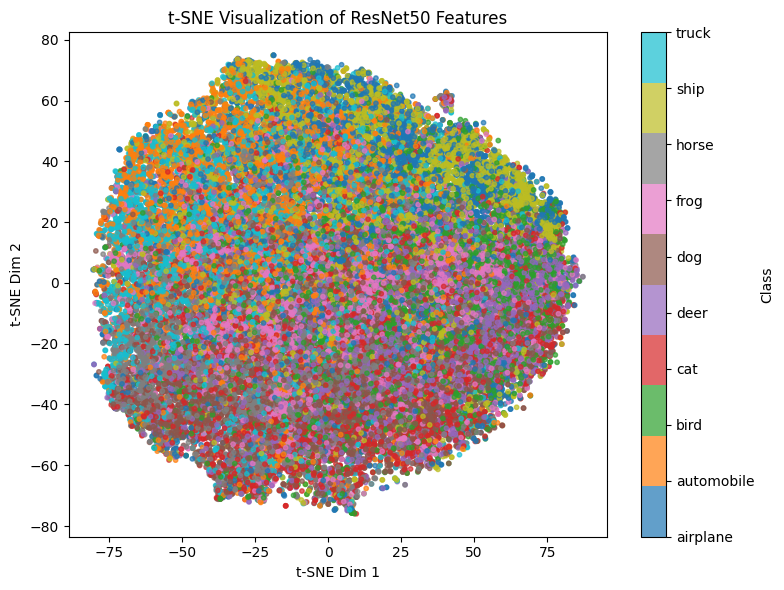

Saved in results/figures/02_tsne_visualization.png


In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
labels_tsne = training_labels[:features_2d.shape[0]]

scatter = ax.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=labels_tsne,
    cmap='tab10',
    s=10,
    alpha=0.7
)

# Colorbar with class names
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Class")
cbar.set_ticks(range(len(class_names)))
cbar.set_ticklabels(class_names)

ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_title("t-SNE Visualization of ResNet50 Features")

plt.tight_layout()
plt.savefig('../results/figures/02_tsne_visualization.png', dpi=150)
plt.show()

print("Saved in results/figures/02_tsne_visualization.png")


**In the plot:**
- Each point is one CIFAR-10 image represented in 2D using t-SNE
- Colors represent class labels (airplane, automobile, bird, etc)
- The 2048-dimensional ResNet50 features were reduced to 50 dimensions (PCA), nd then to 2 dimensions (t-SNE)

**Plot conclusions:**
- Although not perfect, similar classes tend to be near each other: birds near airplanes, trucks near automobiles, cats near dogs, and horses near deer. **Images that look similar appear close together**
- A lot of overlaps:
    - Animals share textures and shapes → overlapping regions
    - Vehicles share edges, metallic textures → another overlapping region

### Feature Space Analysis by Class

Let's see how well separated different classes are in the reduced feature space.

In [10]:
from scipy.spatial.distance import pdist, squareform

class_centroids = []      # For each class
for i in range(10):
    mask = training_labels == i
    centroid = clean_features_reduced[mask].mean(axis=0)
    class_centroids.append(centroid)

class_centroids = np.array(class_centroids)
distance_matrix = squareform(pdist(class_centroids, metric='euclidean'))
distances = distance_matrix[distance_matrix > 0]
print(f"Mean inter-class distance: {distances.mean():.4f}")
print(f"Std inter-class distance:  {distances.std():.4f}")

# Finding 10 closest pairs:
print("\nMost similar class pairs:")
pairs = np.argsort(distance_matrix.flatten())

shown = 0
for idx in pairs:
    r, c = divmod(idx, 10)
    if r != c:
        print(f"{class_names[r]} ↔ {class_names[c]}    distance: {distance_matrix[r, c]:.4f}")
        shown += 1
    if shown == 10:
        break

Mean inter-class distance: 0.2510
Std inter-class distance:  0.0967

Most similar class pairs:
bird ↔ deer    distance: 0.0600
deer ↔ bird    distance: 0.0600
cat ↔ dog    distance: 0.0724
dog ↔ cat    distance: 0.0724
airplane ↔ ship    distance: 0.1007
ship ↔ airplane    distance: 0.1007
cat ↔ frog    distance: 0.1124
frog ↔ cat    distance: 0.1124
truck ↔ automobile    distance: 0.1235
automobile ↔ truck    distance: 0.1235


Surprisingly, bird and deers have the closest pairs. This does not mean they are necessarily similar in nature, but the CIFAR-10 pictures in both of them probably contain:
- outdoor backgrounds
- natural textures
- soft edges
- similar color variation, such as browns and greens

Also, we notice that animals tend to cluster near animals, whereas vehicles cluster near vehicles

It's reasonable to conclude that it's not perfect since ResNet50 is pretrained on ImageNet, not CIFAR-10

### Visualize Class Separation Heatmap

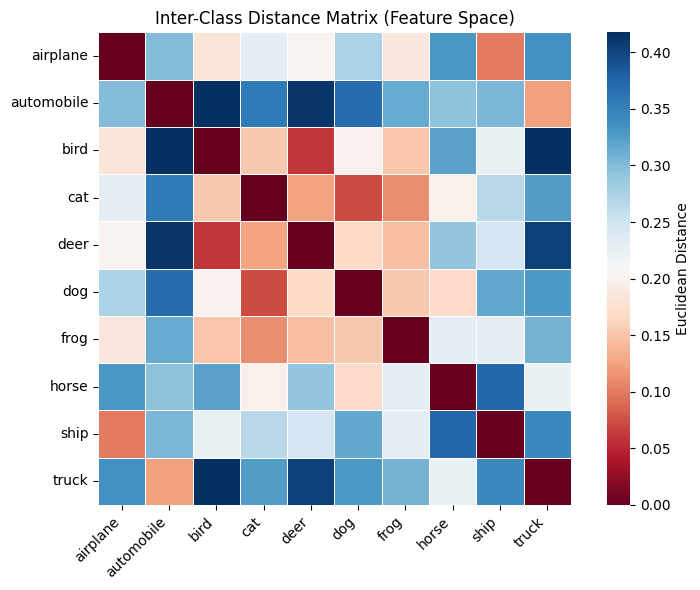

Saved in results/figures/02_class_distance_matrix.png


In [11]:
plt.figure(figsize=(8, 6))

sns.heatmap(
    distance_matrix,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='RdBu',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Euclidean Distance'}
)

plt.title('Inter-Class Distance Matrix (Feature Space)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('../results/figures/02_class_distance_matrix.png')
plt.show()

print("Saved in results/figures/02_class_distance_matrix.png")

- We can see that automobile, truck, and ships are farther from animals (more blue/cooler). This makes sense since their visual features such as textures, straight edges, and shapes differ from animals.

- The most separated classes (highest distances) involve:
    - airplane and frog
    - automobile and frog
    - truck and cat

### Save Extracted Features

Let's save features to disk for use in adversarial attack generation and TDA analysis:

In [12]:
# Save original 2048-dim features:
extractor.save_features(
    clean_features,
    training_labels,
    '../results/features/clean_features_original.npz',
)

# Save reduced 50-dim features:
np.savez_compressed(
    '../results/features/clean_features_reduced.npz',
    features=clean_features_reduced,
    labels=training_labels,
    n_components=50,
    variance_explained=reducer.pca.explained_variance_ratio_.sum()
)

print("\nSaved reduced features in results/features/clean_features_reduced.npz")

Features saved to ../results/features/clean_features_original.npz

Saved reduced features in results/features/clean_features_reduced.npz


### Summary

Feature extraction complete! Here's what we accomplished:

In [13]:
print(f"✓ Processed {len(clean_features):,} images")
print(f"✓ Extracted {clean_features.shape[1]:,}-dimensional features (ResNet50)")
print(f"✓ Reduced to {clean_features_reduced.shape[1]}-dimensional space (PCA)")
print(f"✓ Preserved {reducer.pca.explained_variance_ratio_.sum():.2%} of variance")

print("\n Generated Files:")
print("✓ clean_features_original.npz (2048-dim features)")
print("✓ clean_features_reduced.npz (50-dim features)")

print("\nMade Visualizations:")
print("✓ 02_pca_variance.png")
print("✓ 02_tsne_visualization.png")
print("✓ 02_class_distance_matrix.png")

print("\nNext Steps:")
print("→ Implement FGSM attack")
print("→ Implement PGD attack")
print("→ Go through adversarial examples")
print("→ Extract features from those adversarial images")
print("→ Compare clean vs adversarial feature distributions")

✓ Processed 45,000 images
✓ Extracted 2,048-dimensional features (ResNet50)
✓ Reduced to 50-dimensional space (PCA)
✓ Preserved 96.25% of variance

 Generated Files:
✓ clean_features_original.npz (2048-dim features)
✓ clean_features_reduced.npz (50-dim features)

Made Visualizations:
✓ 02_pca_variance.png
✓ 02_tsne_visualization.png
✓ 02_class_distance_matrix.png

Next Steps:
→ Implement FGSM attack
→ Implement PGD attack
→ Go through adversarial examples
→ Extract features from those adversarial images
→ Compare clean vs adversarial feature distributions
